Add our codebase to the `LOAD_PATH`, and load various libraries.

In [1]:
push!(LOAD_PATH, "../code")

3-element Array{Any,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.6"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.6"      
 "../code"                                                         

In [2]:
using Aldebaran
using CARMA
using Ensemble
using HDF5
using CARMAKepler
using Optim
using Periodogram
using PyCall
using PyPlot

import Base.convert

@pyimport seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

@pyimport corner

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] @vectorize_2arg(::ANY, ::ANY) at ./deprecated.jl:339
 [3] include_from_node1(::String) at ./loading.jl:576
 [4] include(::String) at ./sysimg.jl:14
 [5] include_from_node1(::String) at ./loading.jl:576
 [6] eval(::Module, ::Any) at ./boot.jl:235
 [7] _require(::Symbol) at ./loading.jl:490
 [8] require(::Symbol) at ./loading.jl:405
 [9] include_from_node1(::String) at ./loading.jl:576
 [10] eval(::Module, ::Any) at ./boot.jl:235
 [11] _require(::Symbol) at ./loading.jl:490
 [12] require(::Symbol) at ./loading.jl:405
 [13] include_from_node1(::String) at ./loading.jl:576
 [14] eval(::Module, ::Any) at ./boot.jl:235
 [15] _require(::Symbol) at ./loading.jl:490
 [16] require(::Symbol) at ./loading.jl:405
 [17] include_string(::String, ::String) at ./loading.jl:522
 [18] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [19] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /

We want to load timeseries of *all* data (`ts`, `ys`, `dys`) and also all the data before the SONG observations: (`ts_ps`, `ys_ps`, `dys_ps`).

In [27]:
ts, ys, dys = Aldebaran.load_timeseries();
ts_ps, ys_ps, dys_ps = Aldebaran.load_timeseries(before_song=true, song=false);

In [28]:
tmed = median(vcat(ts...))
ts = [t-tmed for t in ts];

In [29]:
tmin = minimum([minimum(t) for t in ts])
tmax = maximum([maximum(t) for t in ts])
T = tmax - tmin
muHz = 1e-6*(3600.0*24.0);

Let's look at the periodogram over a wide range of frequencies, log-spaced:

In [6]:
fs = exp.(collect(linspace(log(1e-3), log(5*muHz), 10000)))
coeffs = [Periodogram.pgram(ts, ys, dys, f) for f in fs]
rms_amps = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs];

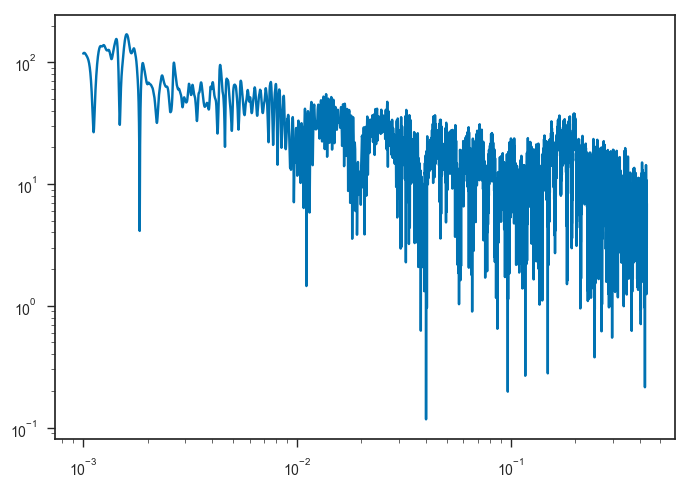

In [7]:
plot(fs, rms_amps)
xscale("log")
yscale("log")

The overall maximum power should (per [Hatzes, et al. (2015)](http://dx.doi.org/10.1051/0004-6361/201425519)) be at the Keplerian orbital period; in that work, $P = 628.96 \pm 0.90 \, \mathrm{d}$.

In [8]:
Pkep = 1.0/fs[indmax(rms_amps)]

626.6823397842544

There seems to be a "bump" at higher frequency; let's zoom in:

In [47]:
fs_zoom = collect(linspace(1*muHz, 5*muHz, 10000))
coeffs_zoom = [Periodogram.pgram(ts, ys, dys, f) for f in fs_zoom]
rms_amps_zoom = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs_zoom];

And picking out all the time samples that are above an (arbitrary) threshold, we find the following peaks:

In [48]:
rms_peak_threshold = 27
peak_spacing_cut = 1e-3
fs_peaks = fs_zoom[rms_amps_zoom .> rms_peak_threshold]
freqs = []
f = []
for i in 2:size(fs_peaks, 1)-1
    push!(f, fs_peaks[i])
    if fs_peaks[i+1] - fs_peaks[i] > peak_spacing_cut
        push!(freqs, f)
        f = []
    end
end
push!(freqs, f)
freqs = [mean(f) for f in freqs]

5-element Array{Float64,1}:
 0.155065
 0.167209
 0.177933
 0.187591
 0.197874

The peak pattern should be $l = 0$, followed by $l = 1$, followed by $l = 0$, ....  (Thanks, Guy!)  So:

In [49]:
dNu_estimates = vcat(diff(freqs[2:2:end]/muHz), diff(freqs[1:2:end])/muHz)

3-element Array{Float64,1}:
 0.235908
 0.26467 
 0.230809

In [50]:
println(@sprintf("Mean of separation between peak freqs is %.3g +/- %.2g muHz", mean(dNu_estimates), std(dNu_estimates)/sqrt(length(dNu_estimates))))

Mean of separation between peak freqs is 0.244 +/- 0.011 muHz


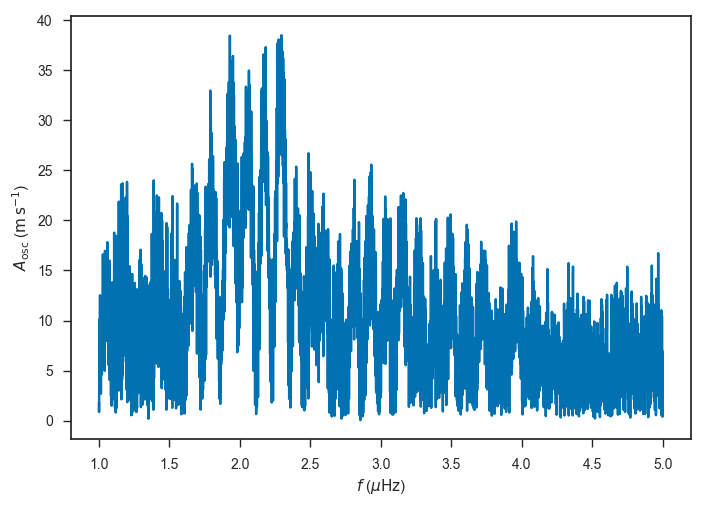

PyObject <matplotlib.text.Text object at 0x159643358>

In [51]:
plot(fs_zoom/muHz, rms_amps_zoom)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

And with the threshold we chose and the peaks we found labelled:

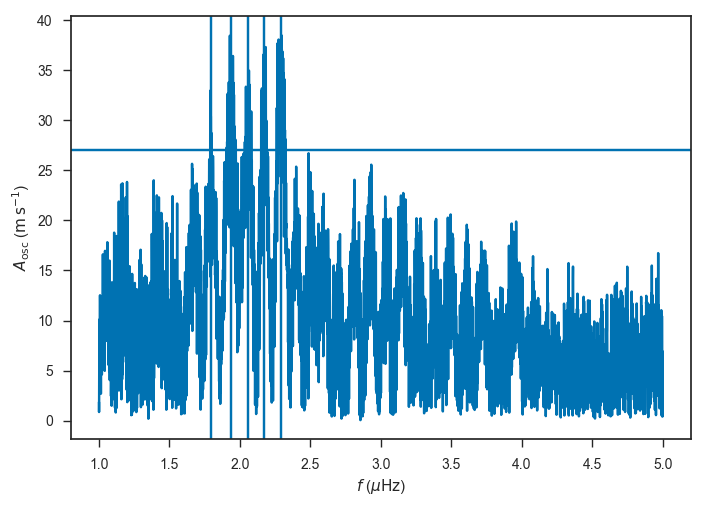

PyObject <matplotlib.text.Text object at 0x159a6f7f0>

In [52]:
plot(fs_zoom/muHz, rms_amps_zoom)
axhline(rms_peak_threshold)
for f in freqs
    axvline(f/muHz)
end
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

What does this plot look like pre-SONG?  Not nearly as nice:

In [53]:
coeffs_zoom_ps = [Periodogram.pgram(ts_ps, ys_ps, dys_ps, f) for f in fs_zoom]
rms_amps_zoom_ps = sqrt.([c[end-1]^2 + c[end]^2 for c in coeffs_zoom_ps]);

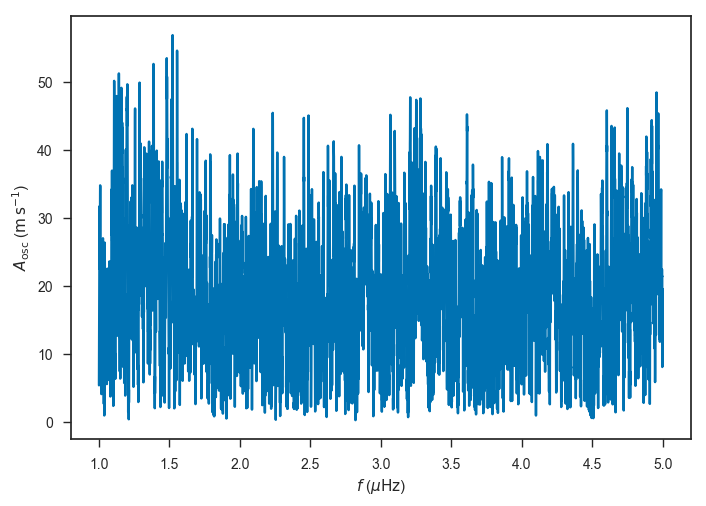

PyObject <matplotlib.text.Text object at 0x15a772cc0>

In [54]:
plot(fs_zoom/muHz, rms_amps_zoom_ps)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

Now let's see if we can find a good orbital solution:

In [36]:
post = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 0, 0.1*muHz, 5*muHz);
p0 = CARMAKepler.to_params(post, zeros(CARMAKepler.nparams(post)))

CARMAKepler.MultiEpochParams([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25], 899.9957168654438, 650.0, NaN, NaN, 0.5, [899.996], [12899.1], Float64[], Float64[], Float64[])

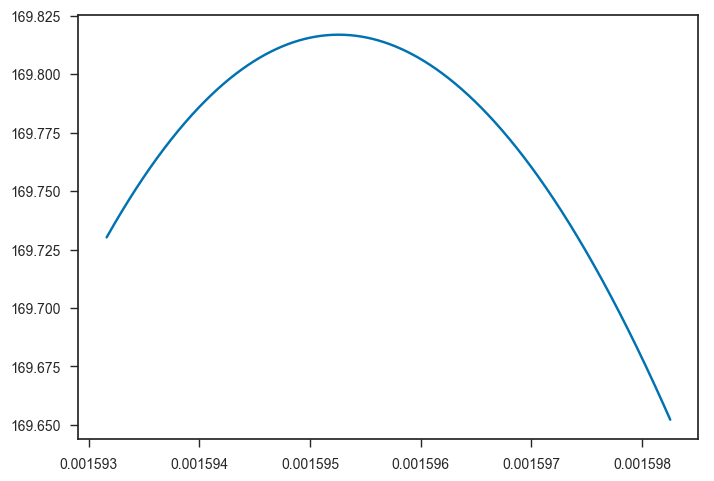

2-element Array{Float64,1}:
 149.074
 -81.331

In [10]:
fs_kep = collect(linspace(1.0/(Pkep+1), 1.0/(Pkep-1), 1000))
coeffs_kep = [Periodogram.pgram(ts, ys, dys, f) for f in fs_kep]
rmss_kep = [sqrt(c[end-1]^2 + c[end]^2) for c in coeffs_kep]
plot(fs_kep, rmss_kep)
Pkep = 1.0/fs_kep[indmax(rmss_kep)]
rms_kep = maximum(rmss_kep)
ckep = coeffs_kep[indmax(rmss_kep)]
Akep, Bkep = coeffs_kep[indmax(rmss_kep)][end-1:end]

In [11]:
p0.mu = ckep[1:end-2]
p0.nu = ones(size(ts, 1))
p0.K = 136.1 #sqrt(Akep^2 + Bkep^2) 
p0.P = Pkep
p0.ecosw = 0.01
p0.esinw = 0.01

p0.chi = atan2(Bkep, Akep)/(2*pi)
if p0.chi < 0.0
    p0.chi += 1
end

p0.drw_rms = [850.0]
p0.drw_rate = [0.07]

p0.osc_rms = Float64[]
p0.osc_freq = Float64[]
p0.osc_Q = Float64[]

0-element Array{Float64,1}

In [12]:
type KeplerParams
    mu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0

function KeplerParams(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    
    i = nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerParams(mu, K, P, e, w, chi)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerParams)
    x = zeros(size(p.mu,1) + 5)
    x[1:size(p.mu, 1)] = p.mu
    
    i = size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    
    x
end

function log_kepler_prior(x::Array{Float64, 1})
    log_kepler_prior(KeplerParams(x))
end
function log_kepler_prior(p::KeplerParams)
    # Flat prior on everything
    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp
end

function log_kepler_likelihood(x::Array{Float64, 1})
    log_kepler_likelihood(KeplerParams(x))
end
function log_kepler_likelihood(p::KeplerParams)
    ll = 0.0
    
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            resid = post.ys[i][j] - p.mu[i] - rv
            
            ll -= 0.5*resid*resid/(post.dys[i][j]*post.dys[i][j])
        end
    end
    
    ll
end

function log_kepler_posterior(x::Array{Float64, 1})
    log_kepler_posterior(KeplerParams(x))
end
function log_kepler_posterior(p::KeplerParams)
    lp = log_kepler_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_likelihood(p)
    end
end

log_kepler_posterior (generic function with 2 methods)

In [14]:
pk = KeplerParams(zeros(size(p0.mu, 1) + 5)+0.01)

pk.mu = p0.mu
pk.K = p0.K
pk.P = p0.P
pk.e = sqrt(p0.ecosw*p0.ecosw + p0.esinw*p0.esinw)
pk.omega = atan2(p0.esinw, p0.ecosw)
pk.chi = p0.chi

0.9205117813591597

In [15]:
xk = convert(Array{Float64, 1}, pk)

13-element Array{Float64,1}:
   -37.1854  
    24.0642  
     3.98172 
   -57.8592  
    11.1452  
     3.80603 
     1.57845 
 54300.1     
   136.1     
   626.858   
     0.010002
     0.010002
     2.44932 

In [73]:
res = Optim.optimize(x -> -log_kepler_likelihood(x), xk, NelderMead(), Optim.Options(iterations=10000))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-37.18539941947494,24.064184541552102, ...]
 * Minimizer: [-31.490004453303918,15.628888186937612, ...]
 * Minimum: 1.389676e+05
 * Iterations: 3811
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 5627

In [74]:
xmin = Optim.minimizer(res)
pmin = KeplerParams(xmin)

KeplerParams([-31.49, 15.6289, -3.37295, -83.1213, 6.92604, -21.6193, 0.0783711, 54273.2], 171.134176110376, 627.3397783199376, 0.2598874187223338, -0.4528522754526715, 0.8902224267953238)

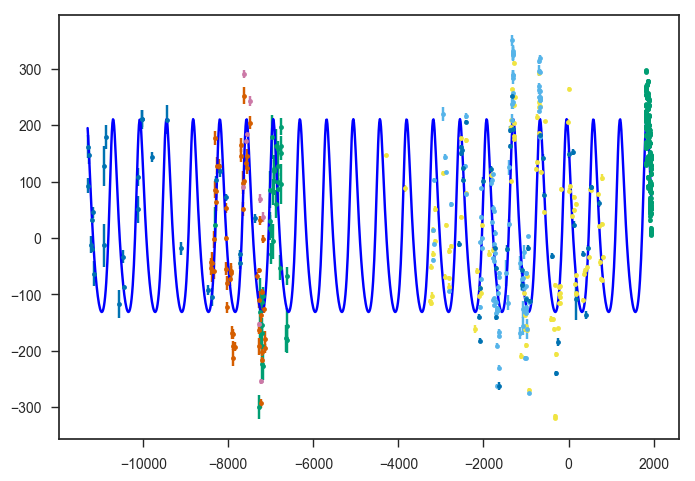

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1594fe128>

In [76]:
for i in eachindex(post.ts)
    errorbar(post.ts[i], post.ys[i]-pmin.mu[i], post.dys[i], fmt=".")
end
tsp = collect(linspace(tmin, tmax, 1000))
rvs = [Kepler.rv(t, pmin.K, pmin.P, pmin.e, pmin.omega, pmin.chi) for t in tsp]
plot(tsp, rvs, "-b")

In [78]:
Optim.initial_state(res)-Optim.minimizer(res)

13-element Array{Float64,1}:
  -5.69539 
   8.4353  
   7.35467 
  25.2621  
   4.2192  
  25.4254  
   1.50008 
  26.9113  
 -35.0342  
  -0.481807
  -0.240617
   0.131947
   0.356306

In [84]:
xs = broadcast((+), xmin, 1e-5*randn(size(xmin,1), 128))

13×128 Array{Float64,2}:
   -31.49        -31.49         -31.49       …    -31.49        -31.49    
    15.6289       15.6289        15.6289           15.6289       15.6289  
    -3.37294      -3.37295       -3.37294          -3.37298      -3.37294 
   -83.1213      -83.1213       -83.1213          -83.1213      -83.1213  
     6.92603       6.92604        6.92604           6.92603       6.92604 
   -21.6193      -21.6193       -21.6193     …    -21.6193      -21.6193  
     0.078377      0.0783588      0.0783838         0.078359      0.07838 
 54273.2       54273.2        54273.2           54273.2       54273.2     
   171.134       171.134        171.134           171.134       171.134   
   627.34        627.34         627.34            627.34        627.34    
     0.250608      0.250617       0.250634   …      0.250625      0.250608
    -0.121928     -0.121941      -0.12195          -0.121931     -0.121933
     2.09301       2.09301        2.09301           2.09303       2.09303 

In [85]:
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_posterior)

128-element Array{Float64,1}:
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
  ⋮       
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5

In [86]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_posterior, 128, callback=EnsembleSampler.basic_callback)

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-138970.2, -138976.0, 7.6)
    ACLs are [47.1,44.3,77.1,75.8,36.7,54.9,33.4,54.8,39.4,Inf,58.1,46.9,43.9]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [35.7,62.5,30.6,30.6,29.7,67.8,40.5,35.6,25.1,42.0,63.1,Inf,43.1]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-138970.5, -138976.7, 6.5)
    ACLs are [23.6,89.6,20.1,22.3,18.5,44.2,13.5,38.4,45.4,33.0,43.9,15.5,25.3]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [10.5,14.8,20.1,25.7,19.5,27.0,14.5,21.8,12.5,36.5,11.5,34.8,31.0]
Advanced for 16384 steps (thin = 16); (max, mean, var)(log(pi)) = (-138970.7, -138976.7, 6.5)
    ACLs are [13.1,8.8,14.7,9.3,7.0,10.4,12.0,15.6,15.0,10.8,12.7,8.3,7.3]
Advanced for 32768 steps (thin = 32); (max, mean, var)(log(pi)) = (-138970.6, -138976.7, 6.5)
    ACLs are [6.2,5.7,4.8,5.3,4.9,4.7,6.5,4.5,5.0,5

([-34.435 -32.0391 … -34.3795 -29.0583; 14.9909 15.8239 … 15.1805 21.5342; … ; -0.117794 -0.120721 … -0.117328 -0.122577; 2.10215 2.10125 … 2.11384 2.09273]

[-33.5856 -32.0096 … -32.2643 -30.4439; 19.6287 14.3392 … 13.5513 24.0578; … ; -0.119342 -0.12132 … -0.118674 -0.121436; 2.09911 2.09988 … 2.10535 2.09309]

[-33.2239 -30.5872 … -31.9274 -30.8013; 18.4623 14.8671 … 14.9329 19.949; … ; -0.120713 -0.119159 … -0.117136 -0.121363; 2.09722 2.09747 … 2.10683 2.09331]

...

[-34.7406 -30.4471 … -29.0208 -28.2412; 13.3078 20.9638 … 19.9829 14.4674; … ; -0.121147 -0.11943 … -0.1234 -0.12376; 2.10603 2.0978 … 2.08517 2.08034]

[-32.7929 -31.2705 … -29.9117 -28.1555; 16.5142 21.2999 … 18.8426 15.306; … ; -0.121034 -0.120542 … -0.124608 -0.122696; 2.1068 2.09395 … 2.08358 2.08225]

[-31.9601 -30.8698 … -29.3612 -29.5757; 16.6291 21.6491 … 21.8993 15.215; … ; -0.122013 -0.121389 … -0.123326 -0.121024; 2.09658 2.08654 … 2.09303 2.09695], [-1.38981e5 -1.38979e5 … -1.38976e5 -1.38975e5; -1.38975e

In [89]:
ps = [KeplerParams(xs[:,j,k]) for j in 1:size(xs,2) for k in 1:size(xs, 3)];

In [91]:
h5open("pure-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in ps]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in ps]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in ps]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in ps]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in ps]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in ps]
end;

In [13]:
h5open("pure-kepler.h5", "r") do f
    global mus = read(f, "mu")
    global Ks = read(f, "K")
    global Ps = read(f, "P")
    global es = read(f, "e")
    global omegas = read(f, "omega")
    global chis = read(f, "chi")
end
ps = [KeplerParams(mus[i,:], Ks[i], Ps[i], es[i], omegas[i], chis[i]) for i in eachindex(Ks)];

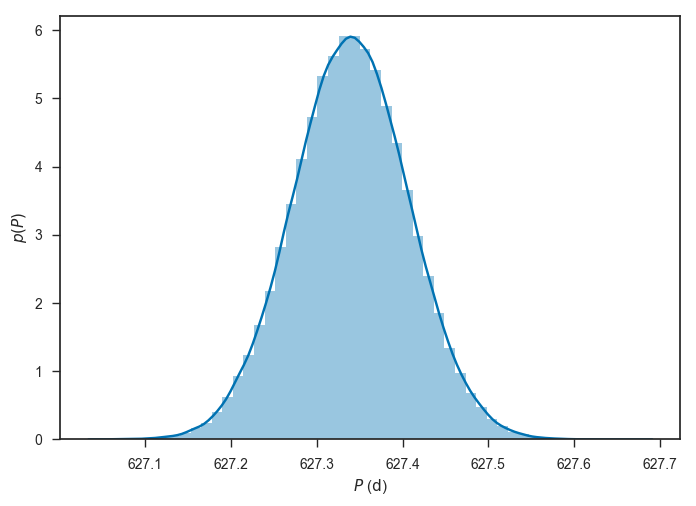

P = 627.340 +/- 0.067 d


In [14]:
sns.distplot([p.P for p in ps])
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")
println(@sprintf("P = %.3f +/- %.3f d", mean([p.P for p in ps]), std([p.P for p in ps])))

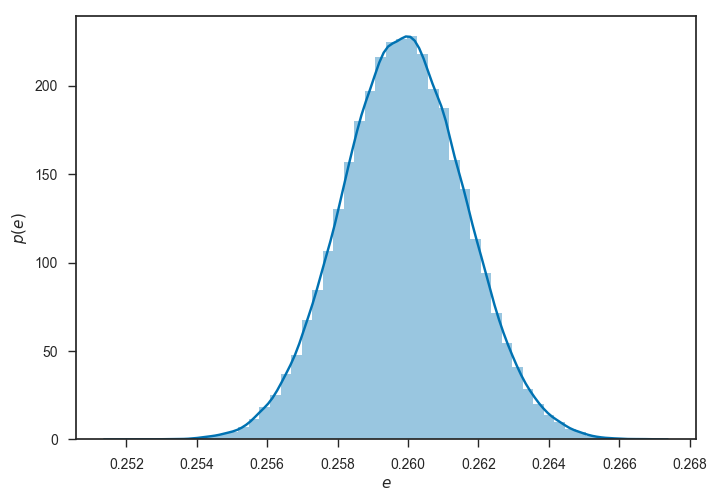

e = 0.2599 +/- 0.0017


In [15]:
sns.distplot([p.e for p in ps])
xlabel(L"$e$")
ylabel(L"$p(e)$")
println(@sprintf("e = %.4f +/- %.4f", mean([p.e for p in ps]), std([p.e for p in ps])))

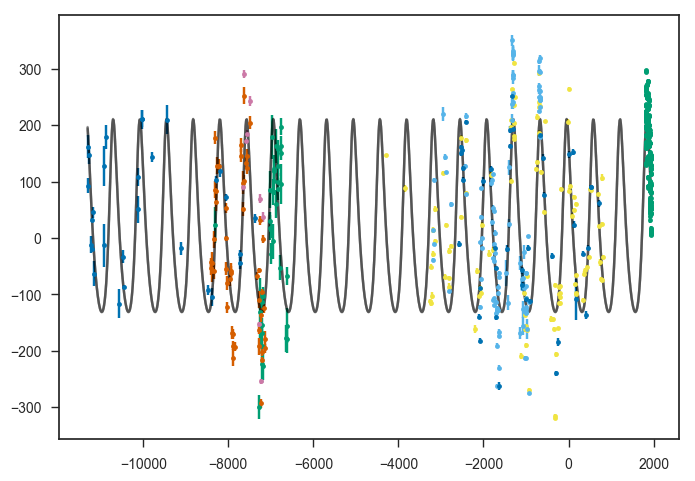

In [16]:
mu_mu = vec(mean(hcat([p.mu for p in ps]...), 2))
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-mu_mu[i], dys[i], fmt=".")
end
ts_plot = collect(linspace(tmin, tmax, 1000))
for i in 1:10
    j = rand(1:size(ps, 1))
    p = ps[j]
    rvs = [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts_plot]
    plot(ts_plot, rvs, color="k", alpha=0.1)
end

In [107]:
type KeplerAR1Params
    mu::Array{Float64, 1}
    nu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
    sigma::Float64
    tau::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0
dt_min = minimum(diff(sort(post.allts)))
T = tmax-tmin

function KeplerAR1Params(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    nu = Parameterizations.bounded_value(x[nseg+1:2*nseg], 0.5, 2.0)
    
    i = 2*nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    i = i+1
    
    sigma = exp(x[i])
    i = i+1
    
    tau = exp(x[i])
    i = i+1
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerAR1Params(mu, nu, K, P, e, w, chi, sigma, tau)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerAR1Params)
    x = zeros(2*size(p.mu,1) + 7)
    x[1:size(p.mu, 1)] = p.mu
    x[size(p.mu,1)+1:2*size(p.mu,1)] = Parameterizations.bounded_param(p.nu, 0.5, 2.0)
    
    i = 2*size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    i = i+1
    
    x[i] = log(p.sigma)
    i = i+1
    
    x[i] = log(p.tau)
    i = i+1

    x
end

function log_kepler_ar1_prior(x::Array{Float64, 1})
    log_kepler_ar1_prior(KeplerAR1Params(x))
end
function log_kepler_ar1_prior(p::KeplerAR1Params)
    # Flat prior on everything
    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp += Parameterizations.bounded_logjac(p.nu, Parameterizations.bounded_param(p.nu, 0.5, 2.0), 0.5, 2.0)
    
    lp
end

function log_kepler_ar1_likelihood(x::Array{Float64, 1})
    log_kepler_ar1_likelihood(KeplerAR1Params(x))
end
function log_kepler_ar1_likelihood(p::KeplerAR1Params)
    ll = 0.0
    
    ts = Float64[]
    resid = Float64[]
    dys = Float64[]
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            r = post.ys[i][j] - p.mu[i] - rv
            
            push!(ts, post.ts[i][j])
            push!(resid, r)
            push!(dys, post.dys[i][j]*p.nu[i])
        end
    end
    
    inds = sortperm(ts)
    ts = ts[inds]
    resid = resid[inds]
    dys = resid[inds]
    
    kpost = Kalman.AR1KalmanPosterior(ts, resid, dys)
    kparams = Kalman.AR1KalmanParams(0.0, p.sigma, 1.0, p.tau)
    
    Kalman.log_likelihood(kpost, kparams)
end

function log_kepler_ar1_posterior(x::Array{Float64, 1})
    log_kepler_ar1_posterior(KeplerAR1Params(x))
end
function log_kepler_ar1_posterior(p::KeplerAR1Params)
    lp = log_kepler_ar1_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_ar1_likelihood(p)
    end
end

log_kepler_ar1_posterior (generic function with 2 methods)

In [54]:
pkep = ps[rand(1:size(ps,1))]
par = KeplerAR1Params(zeros(2*size(ts, 1) + 8))

par.mu = pkep.mu
par.nu = ones(size(ts, 1))
par.K = pkep.K
par.P = pkep.P
par.e = pkep.e
par.omega = pkep.omega
par.chi = pkep.chi
par.sigma = 50.0
par.tau = 1000.0

1000.0

In [99]:
res = Optim.optimize(x -> -log_kepler_ar1_likelihood(x), xmin, NelderMead(), Optim.Options(iterations=10000))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-9.875063301943845,-3.787645879541786, ...]
 * Minimizer: [7.14497181009089,6.856277549835748, ...]
 * Minimum: 3.572482e+03
 * Iterations: 7163
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 10156

In [105]:
xmin = Optim.minimizer(res)
pmin = KeplerAR1Params(xmin)

pmin.nu[pmin.nu .== 0.5] = 0.51
pmin.nu[pmin.nu .== 2.0] = 1.99

xmin = convert(Array{Float64, 1}, pmin)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] convert(::Type{Array{Float64,1}}, ::KeplerAR1Params) at ./In[103]:55
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [7] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[105], in expression starting on line 7


23-element Array{Float64,1}:
     7.14497  
     6.85628  
   -22.5888   
   -46.7434   
     5.09893  
    -7.03973  
    22.1584   
 54296.0      
     2.26388  
    -3.93475  
    -0.0508323
    -0.0485695
    23.2996   
   -19.2137   
     5.5906   
    -5.00395  
   156.704    
   629.267    
     0.125767 
    -0.208033 
     1.52418  
     4.17811  
     2.47958  

In [109]:
xs = broadcast((+), xmin, 1e-3*randn(size(xmin,1), 128))
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_ar1_posterior);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[107]:99
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[107]:139
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[109], in expression starting on line 2


In [117]:
function cb(pts, lnprobs, n, thin)
     h5open("/tmp/state.save.h5.temp", "w") do f
        f["pts", "shuffle", (), "compress", 3] = pts
    end
    mv("/tmp/state.save.h5.temp", "/tmp/state.save.h5", remove_destination=true)
    EnsembleSampler.basic_callback(pts, lnprobs, n, thin)
end

cb (generic function with 1 method)

In [118]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_ar1_posterior, 128, callback=cb)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[107]:99
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[107]:139
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] update_half(::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:69
 [7] update(::Array{Float64,2}, ::Array{Float64,1}, ::Function) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:110
 [8] #run_mcmc#1(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:129
 [9] (::Ensemble.EnsembleSampler.#kw##run_mcmc)(::Array{Any,1}, ::Ensemble.EnsembleSampler.#run_mcmc, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at ./<missing>:0
 [10] #run_to_neff#4(:

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-3587.2, -3620.4, 475.4)
    ACLs are [Inf,82.5,97.0,Inf,99.8,Inf,Inf,Inf,Inf,Inf,83.2,87.8,Inf,Inf,Inf,Inf,79.7,89.7,Inf,80.7,Inf,61.7,98.4]
Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-3585.3, -3596.7, 17.0)
    ACLs are [67.8,96.0,99.4,Inf,Inf,Inf,Inf,96.5,64.5,Inf,Inf,Inf,Inf,Inf,Inf,94.2,Inf,67.5,93.0,Inf,79.5,Inf,77.4]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-3585.6, -3596.3, 16.1)
    ACLs are [33.5,41.3,98.1,26.3,75.3,72.5,Inf,39.3,38.2,69.0,66.1,Inf,80.0,71.0,87.5,79.9,40.4,54.2,Inf,Inf,Inf,36.3,56.1]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-3585.5, -3596.4, 15.7)
    ACLs are [57.8,Inf,50.0,79.2,99.0,80.1,Inf,35.0,Inf,53.8,45.5,50.5,32.7,40.4,65.4,34.3,32.8,29.9,35.9,56.7,41.7,53.4,64.7]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-3584.8, -3596.4, 15.9)
    ACLs are [53.4,Inf,35.6,50.2,85.9,35.4,68.1,82.4,21.9,16.8,46.8,

LoadError: [91mInterruptException:[39m

In [120]:
ps = KeplerAR1Params[]
for j in 1:size(xs, 2)
    for k in 1:size(xs, 3)
        push!(ps, KeplerAR1Params(xs[:,j,k]))
    end
end

In [121]:
h5open("ar1-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in ps]...)
    f["nu", "compress", 3, "shuffle", ()] = vcat([p.nu' for p in ps]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in ps]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in ps]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in ps]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in ps]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in ps]
    f["sigma", "compress", 3, "shuffle", ()] = [p.sigma for p in ps]
    f["tau", "compress", 3, "shuffle", ()] = [p.tau for p in ps]
end;